# Modelos pré-treinados e transferência de conhecimento

### imports

In [54]:
from pathlib import Path
import os

import keras
from keras import layers, utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras.src.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.src.applications.mobilenet_v3 import MobileNetV3Large, decode_predictions
from tensorflow.keras.models import Model
import cv2

base_dir = Path(os.getcwd()).resolve().parent
base_dir

WindowsPath('C:/Users/diogo/Desktop/ISCTE/Semestre 2/APVC/Aulas/Semana 6')

## Exercício 1 (Rede CNN pré-treinada – VGG16 e MobileNet)

##### 1.1  Consulte  https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/ e  veja  a  lista  de  1000  classes  associadas  ao  dataset  ImageNet.  Procure  na  internet algumas imagens (sugere-se à volta de 5) que encaixem nessas classes e descarregue-as

- Podemo visualizar as imagens no na pasta ```Aulas\Semana 6\sample_images```

##### 1.2. Verifique o resultado da classificação das imagens que descarregou usando a rede pré-treinada VGG16. Atenção ao formato dos dados de entrada – é necessário realizar um passo de pré-processamento para que estes fiquem no formato que o modelo é suposto receber. 

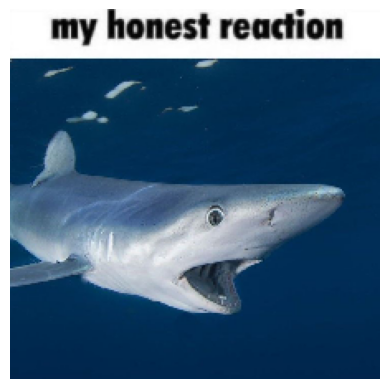

In [55]:
# Load the VGG-16 model
vgg16Model = VGG16(weights='imagenet', classes=1000)

# a sample image - change it to your own image
IMG_FILE = base_dir / 'sample_images' / 'whiteShark.jpg'

# image size constants - 224x224 is the input image dimension for the VGG-16 CNN
IMG_HEIGHT = 224
IMG_WIDTH = 224

# loads the sample image, and resizes it for the desired dimension (PIL format)
img = utils.load_img(IMG_FILE, target_size=(IMG_HEIGHT, IMG_WIDTH))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

# the sample image requires a few preprocessing steps in order to make it compatible with the VGG-16 model
x = utils.img_to_array(img)       # converts the image from PIL format to numpy array
x = np.expand_dims(x, axis=0)     # creates an additional dimension that represents the batch (we have a single batch containing a single image)
x = preprocess_input(x)           # VGG-16 specific preprocessing (basically a VGG-16 library function that converts the images to BGR and normalizes
                                  # the pixel values by subtracting a predefined offset)

In [56]:
# get the predictions (returns the output of the 1000 neurons at the VGG-16's output layer)
preds = vgg16Model.predict(x)

# process the predictions using a VGG-16's library function - in this case it was setup to get the 5 most probable classes
decoded_preds = keras.src.applications.vgg16.decode_predictions(preds, top=5)[0]

# Shows the classification results
print('Top-5 Class predictions: ')
for class_name, class_description, score in decoded_preds:
    print(class_description, ":", score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Top-5 Class predictions: 
hammerhead : 0.40996355
tiger_shark : 0.34772584
great_white_shark : 0.24227904
sturgeon : 2.3233357e-05
coho : 5.1672014e-06


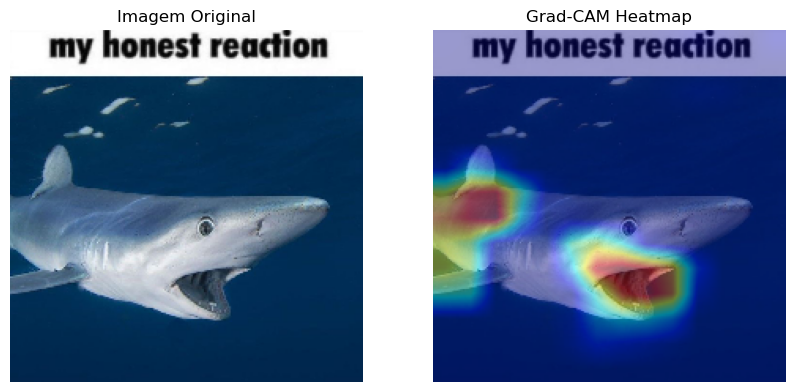

In [57]:
# Obter a última camada convolucional
last_conv_layer = vgg16Model.get_layer("block5_conv3")
grad_model = Model(inputs=vgg16Model.input, outputs=[last_conv_layer.output, vgg16Model.output])

# Calcular os gradientes
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    class_idx = np.argmax(predictions[0])  # Classe predita mais provável
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Aplicar os gradientes à última camada convolucional
conv_outputs = conv_outputs[0]
heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)

# Normalizar o heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Redimensionar e aplicar colormap
heatmap = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Sobrepor o heatmap na imagem original
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

# Mostrar os resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title("Imagem Original")

ax[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title("Grad-CAM Heatmap")

plt.show()

##### 1.3. Altere  a  rede  pré-treinada  para  uma  das  versões  do  modelo  MobileNet.  Consulte  a documentação em  https://www.tensorflow.org/api_docs/python/tf/keras/applications para verificar os argumentos que pode passar quando se cria o modelo e para verificar se  a  versão  que  escolheu  necessita  ou  não  de  algum  tipo  de  pré-processamento  aos dados.

In [58]:
from tensorflow.keras.applications import MobileNetV3Large

# Carregar o modelo MobileNetV3 Large
mobilenet_v3_large = MobileNetV3Large(weights='imagenet', classes=1000)


c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


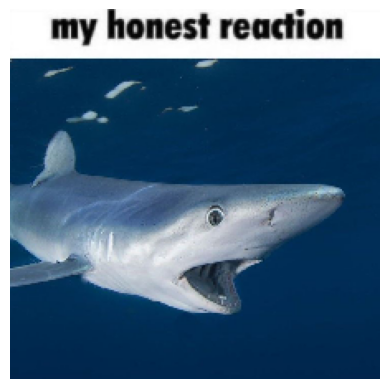

In [59]:
# a sample image - change it to your own image
IMG_FILE = base_dir / 'sample_images' / 'whiteShark.jpg'

# image size constants - 224x224 is the input image dimension for the VGG-16 CNN
IMG_HEIGHT = 224
IMG_WIDTH = 224

# loads the sample image, and resizes it for the desired dimension (PIL format)
img = utils.load_img(IMG_FILE, target_size=(IMG_HEIGHT, IMG_WIDTH))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

x = utils.img_to_array(img)       # converts the image from PIL format to numpy array
x = np.expand_dims(x, axis=0)     # creates an additional dimension that represents the batch (we have a single batch containing a single image)

##### 1.4. Repita o ponto 2, usando agora a versão da MobileNet que escolheu. Verificou diferenças significativas? 

In [60]:
# get the predictions (returns the output of the 1000 neurons at the VGG-16's output layer)
preds = mobilenet_v3_large.predict(x)

# process the predictions using a VGG-16's library function - in this case it was setup to get the 5 most probable classes
decoded_preds = keras.src.applications.mobilenet_v3.decode_predictions(preds, top=5)[0]

# Shows the classification results
print('Top-5 Class predictions: ')
for class_name, class_description, score in decoded_preds:
    print(class_description, ":", score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top-5 Class predictions: 
tiger_shark : 0.7573211
great_white_shark : 0.08514509
hammerhead : 0.020549586
sturgeon : 0.0022920722
barracouta : 0.0015282768


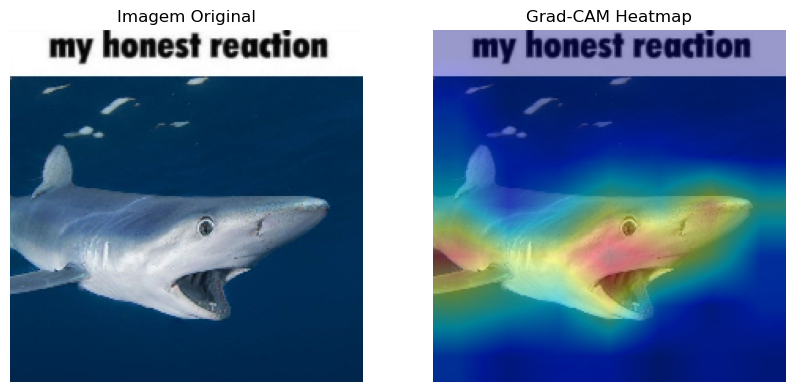

In [61]:
# Obter a última camada convolucional
last_conv_layer = mobilenet_v3_large.get_layer("conv_1")
grad_model = Model(inputs=mobilenet_v3_large.input, outputs=[last_conv_layer.output, mobilenet_v3_large.output])

# Calcular os gradientes
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    class_idx = np.argmax(predictions[0])  # Classe predita mais provável
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Aplicar os gradientes à última camada convolucional
conv_outputs = conv_outputs[0]
heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)

# Normalizar o heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Redimensionar e aplicar colormap
heatmap = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Sobrepor o heatmap na imagem original
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

# Mostrar os resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title("Imagem Original")

ax[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title("Grad-CAM Heatmap")

plt.show()

Sim, existem mudanças significativas